A fine-tuned language model for pictionary word list completion (topic/category phrase + example words -> list of 30 examples). For example, one may complete the list

"A list of round fruits: peach, apricot, lime, plum,"

with

"mango, cherry, pineapple, strawberry, pumpkin, watermelon, orange, pomegranate, melon, apple, pear, grapefruit, papaya, lemon, kiwi, passionfruit, blueberry, raspberry, blackberry, cantaloupe, nectarine, pitaya, persimmon, durian, guava, jackfruit, avocado, lychee, soursop, guarana, mangosteen, blackcurrant, cranberry"

using this model. These words should be compatible with pictionary/skribbl.io; i.e., "sketchable" within a few minutes, and easily recognisable. Scroll to the end for more examples, or see the file `data/examples.txt`. Sketchability parameter estimation examples can also be found in `data/data.tsv`.

In [1]:
import os
import openai

In [2]:
with open('../../openai-api-org.txt', 'r') as f:
    openai.organization = f.read()
with open('../../openai-api-key.txt', 'r') as f:
    openai.api_key = f.read()

In [3]:
import csv
import time
import string
import jsonlines
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from IPython.utils import io
from IPython.display import clear_output
from transformers import GPT2ForSequenceClassification, GPT2LMHeadModel, GPTNeoForCausalLM, ReformerModelWithLMHead, \
                         get_linear_schedule_with_warmup
from pytorch_transformers import GPT2Tokenizer
from transformers import GPT2TokenizerFast
from Learning import *

I0922 00:56:19.389209 94548 modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I0922 00:56:19.400181 94548 modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Complete.


In [4]:
   ###   Options   ###

model_name = "ernst_one"
gpt2_modelkey = "gpt2"               # Pretrained model to start from
# gpt2_modelkey = "gpt2-xl"
test_set_frac = 0.25                 # Fraction of samples to keep as separate test set (word lists)
TsN = 200                            # Number of randomly generated prompts for each sample when validating model
log_period_batches = 10               # Batches per iteration
# learning_rate = 5e-7                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
learning_rate = 7e-5
# learning_rate = 4e-6
adam_epsilon = 1e-8                  # Adam epsilon (default is 1e-8)
n_sched_warmup = 0                   # Linear scheduler for optimizer number of warmup steps
# batch_size = bsz = 64                 # Samples per batch
# batch_size = bsz = 16
batch_size = bsz = 8
N_train_batches = int(1e7 / bsz)     # Total number of batches to show model
max_listlen = 256                    # Maximum number of list phrases for creating a training prompt (at least prior to * max_nw)
# max_len = 512                        # Max n. tokens applied prior to *max_nw (tokens)
max_len = 32
lidstone_e = 0.01                    # Smoothing for possible words/subwords which are not in the missing list words set
lastcomma_repl = ',' # 'EOS', ','    # Token optionally used to replace the final comma that ends the generated phrase
use_correct_nouns = True             # Whether to use only correct singular or plural form of category nouns for the given prompt
swap_noun = False                    # Whether to swap plural and singular nouns in prompt
# rng_train = [0, max_listlen]       # Range of prompt list lengths (number of phrases) to generate for training data
rng_train = [3, 5]

In [5]:
dev = "cuda" if pt.cuda.is_available() else "cpu"  # Setup torch device(s)
d = device = pt.device(dev)
# world_size = 1
# rank = 0
# def setup(rank, world_size): 
#     os.environ['MASTER_ADDR'] = '127.0.0.1'
#     os.environ['MASTER_PORT'] = find_free_port()
#     dist.init_process_group("gloo", rank=rank, world_size=world_size)  # initialize the process group
# def cleanup():
#     dist.destroy_process_group()
# # mp.spawn(setup, args=(rank, world_size), nprocs=world_size)
# setup(rank, world_size)

In [6]:
cats, cats_sing, phrases = Listset().load()  # Import word lists dataset

In [7]:
gpt3_tokenizer = GPT2TokenizerFast.from_pretrained(("gpt2-large"), padding=True)
with io.capture_output() as captured:
    tokenizer = GPT2Tokenizer.from_pretrained(gpt2_modelkey.replace("-xl", "-large"), padding=True)
tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    tokenizer.encode("A list of round fruits: apples,"), \
    tokenizer.encode("oranges, pears,"), \
  gpt3_tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
      gpt3_tokenizer.encode("A list of round fruits: apples,"), \
      gpt3_tokenizer.encode("oranges, pears,")

([317, 1351, 286, 2835, 15921, 25, 22514, 11, 48389, 11, 279, 4127, 11],
 [317, 1351, 286, 2835, 15921, 25, 22514, 11],
 [48389, 11, 279, 4127, 11],
 [32, 1351, 286, 2835, 15921, 25, 22514, 11, 48389, 11, 279, 4127, 11],
 [32, 1351, 286, 2835, 15921, 25, 22514, 11],
 [273, 6231, 11, 279, 4127, 11])

In [8]:
lprompts_encoded = [[tokenizer.encode(prompt), "types of" in prompt] for prompt in lprompts]
cats_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e = [[tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
comma_token = pt.tensor(tokenizer.encode(",")[0], device=d)
lprompts_encoded3 = [[gpt3_tokenizer.encode(prompt), "types of" in prompt] for prompt in lprompts]
cats_e3 = [[gpt3_tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e3 = [[gpt3_tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e3 = [[gpt3_tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
comma_token3 = pt.tensor(gpt3_tokenizer.encode(",")[0], device=d)
N_tokens = len(tokenizer)
N_wordlists = len(cats)

In [9]:
lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
lprompts_sing_encoded = [(prmpt, typesof) for (prmpt, typesof) in lprompts_encoded if typesof ^ swap_noun]
lprompts_sing = [tokenizer.decode(prmpt[0].detach().cpu().numpy()) for prmpt in lprompts_sing_encoded]
lprompts_encoded3 = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded3]
cats_e3 = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e3]
cats_sing_e3 = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e3]
phrases_e3 = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e3]
lprompts_sing3_encoded = [(prmpt, typesof) for (prmpt, typesof) in lprompts_encoded3 if typesof ^ swap_noun]
# N_tokens = pt.tensor(N_tokens, device=d)
# max_len = pt.tensor(max_len, device=d)
# bsz = pt.tensor(batch_size, device=d)
# lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
# cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
# cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
# phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
# N_tokens = pt.tensor(N_tokens, device=d)
# max_len = pt.tensor(max_len, device=d)
# bsz = pt.tensor(batch_size, device=d)
lidstone_e = pt.tensor(lidstone_e, device=d)
lid_val = lidstone_e / N_tokens
y_zero = (lid_val).repeat(N_tokens)

In [41]:
# Generate a fixed test set and save to disk, using. This function defines the next list token prediction problem
def gen_truncated_list(prmt, p, rng=rng_train, mlen=max_len):  # prmt = prompt tokens, p = list word/phrase tokens
    tkzs, sent, tkix, wordix = [], [], 0, -1   # rng is the inclusive range of list lengths to generate (number of phrases)
    min_nw, max_nw, min_nt, max_nt = rng[0], int(rng[1]), 0, int(mlen) - len(prmt)
#     incl_words = pt.randperm(len(p))[:min(max_listlen, len(p))]
    incl_words = np.random.choice(len(p), min(len(p), max_nw), replace=False)
    for phz_i in incl_words:
        phz_enc, wordix = p[phz_i], wordix + 1
        tkzs.append((tkix, phz_enc))
        tkix += len(phz_enc)
        sent.append(phz_enc)
        if wordix < min_nw: min_nt = tkix
        if tkix >= max_nt:
            tkix = max_nt
            break
    if min_nt - 1 >= tkix:
        return gen_truncated_list(prmt, p, rng=rng, mlen=mlen)  # rare when max_len is large enough (0.5x max phrase length)
#         print(tkix, min_nt, max_nt, sent)
    sent = pt.hstack(sent)[:max_nt]
    missing_w = [p[i] for i in range(len(p)) if i not in incl_words]
    trunc_ix = np.random.randint(min_nt - 1, tkix)
    trunc_n = min([(trunc_ix - ix) for (ix, enc) in tkzs if ix <= trunc_ix])  # N. end phrase tokens
    missing_w += [enc for (ix, enc) in tkzs if ix >= (trunc_ix - trunc_n)]
    missing_matches = missing_w
    if trunc_n > 0:
        phr_start = trunc_ix - trunc_n
        partial_phr = sent[phr_start:trunc_ix]
        missing_matches = [enc for enc in missing_w if len(enc) >= trunc_n and all(enc[:trunc_n] == partial_phr)]
    next_tokens = [enc[trunc_n] for enc in missing_matches]
    norm = len(next_tokens) * (1.0 + lidstone_e)
    tunit, y_ = pt.tensor(1 / norm, device=d), y_zero.clone()
    for token in next_tokens: y_[token] += tunit
    return pt.hstack([prmt, sent[:trunc_ix]]), y_
def gen_samples_uniform(xcp, xcs, xp, n,
                        rng=rng_train, prompt=None, tknzr=tokenizer, verbose=False, inds=False, mlen=1e9):
    xs, ys, sqlens, j, prmt = [], [], [], 0, None              # Weight testing samples (word lists) exactly uniformly
    if prompt is not None: prmt = pt.tensor(tknzr.encode(prompt), device=d)
    for i in range(len(xcp)):
        x, y, sqlen = [], [], []
        cp, cs, p = xcp[i], xcs[i], xp[i]
        cp_cs = cp + cs
        for m in range(n):
#             prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
#             cat_ix = np.random.randint(len(cp))
#             x_, y_ = gen_truncated_list(pt.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
            cat_ix = np.random.randint(len(cp_cs))  # First uniformly sample a category title
            sing = cat_ix >= len(cp)
            if prompt is None:
                lprmpts = lprompts_sing_encoded if sing else lprompts_encoded
                prmt, _ = lprmpts[np.random.randint(len(lprmpts))]
            x_, y_ = gen_truncated_list(pt.hstack([prmt, cp_cs[cat_ix]]), p, rng=rng, mlen=mlen)
            x.append(x_)
            y.append(y_)
            sqlen.append(len(x_))
            j += 1
            if verbose and j % 100 == 0:
                sys_print("\rDone: " + str(j))
        xs.append(x)
        ys.append(y)
        sqlens.append(sqlen)
    if inds: xs, ys = sum(xs, []), sum(ys, [])
    if verbose: sys_print("\rDone: " + str(j) + ", finished!\n")
    return (xs, ys, sqlens, np.arange(len(xcp)).repeat(n)) if inds else (xs, ys, sqlens)
def gen_samples(xcp, xcs, xp, n,
                rng=rng_train, prompt=None, tknzr=tokenizer, inds=False, mlen=1e9):
    xs, ys, sqlens, j, prmt = [], [], [], 0, None   # Maximise per-batch training diversity by randomly sampling the word lists
    if prompt is not None: prmt = pt.tensor(tokenizer.encode(prompt), device=d)
    xs, ys, sqlens, j = [], [], [], 0
    n_sets, indices = len(xcp), []
    for m in range(n):
        i = np.random.randint(n_sets)
        cp, cs, p = xcp[i], xcs[i], xp[i]
        cp_cs = cp + cs
        cat_ix = np.random.randint(len(cp_cs))  # First uniformly sample a category title
        sing = cat_ix >= len(cp)
        if prompt is None:
            lprmpts = lprompts_sing_encoded if sing else lprompts_encoded
            prmt, _ = lprmpts[np.random.randint(len(lprmpts))]
        x_, y_ = gen_truncated_list(pt.hstack([prmt, cp_cs[cat_ix]]), p, rng=rng, mlen=mlen)
        xs.append(x_)
        ys.append(y_)
        sqlens.append(len(x_))
        indices.append(i)
    return (xs, ys, sqlens, np.asarray(indices)) if inds else (xs, ys, sqlens)

In [42]:
N_test = int(test_set_frac * N_wordlists)
N_train = N_wordlists - N_test
test_idx = np.random.choice(N_wordlists, N_test, replace=False)
# save_ld(test_idx, "test.data")
test_idx = load_ld("test.data")
# test_idx = np.array([0, 2])  # Round fruits and chemical elements
train_idx = [i for i in range(N_wordlists) if i not in test_idx]
print("Train:")
print([cats[i][0] for i in train_idx])
print("Test:")
print([cats[i][0] for i in test_idx])
cats_train, cats_test = [cats[i] for i in train_idx], [cats[i] for i in test_idx]
cats_sing_train, cats_sing_test = [cats_sing[i] for i in train_idx], [cats_sing[i] for i in test_idx]
phrases_train, phrases_test = [phrases[i] for i in train_idx], [phrases[i] for i in test_idx]
cats_e_test, cats_sing_e_test = [cats_e[i] for i in test_idx], [cats_sing_e[i] for i in test_idx]
phrases_e_test = [phrases_e[i] for i in test_idx]
cats_e_train, cats_sing_e_train = [cats_e[i] for i in train_idx], [cats_sing_e[i] for i in train_idx]
phrases_e_train = [phrases_e[i] for i in train_idx]
test_cats = [cats[i][0] for i in test_idx]
test_xs, test_ys, test_sqlens= gen_samples_uniform(cats_e_test, cats_sing_e_test, phrases_e_test, TsN, mlen=max_len,verbose=True)

Train:
['round fruits', 'wild animals', 'microorganisms', 'outback experiences', 'buildings', 'hats', 'holed pasta', 'rod shaped pasta', 'construction sounds', 'sounds of a building', 'biological examples of math in nature', 'non-biological examples of math in nature', 'timbers', 'woodland ecoregions', 'handcrafts', 'communication media', 'storage media', 'winds', 'scientific principles behind showers', 'scientific principles behind rain showers', 'spacecraft types', 'real spacecrafts', 'interpersonal tokens of trust', 'physical tokens that confer trust', 'digital tokens that confer trust']
Test:
['chemical elements', 'dramatic and literature elements', 'vehicles referred to as crafts', 'music', 'scientific cycles', 'machine learning algorithms', 'glassware', 'windings']


c:\python36\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Done: 1600, finished!


In [43]:
# write function that takes a prompt, existing list and sampling params and returns gpt3's next token probs
default_msp = {
  "best_of": 1,
}
default_sp = {
  "temperature": 1.0,
  "top_p": 1.0,
#   "top_k": -1.0,                 # todo: add code to apply this to gpt3 output (top100), max k ~=90, min = 2?
  "presence_penalty": 0.0,
  "frequency_penalty": 0.0,
}
default_params = {
  "engine": "davinci",
  "model": None,
  "max_tokens": 1,
  "temperature": 1.0,
  "top_p": 1.0,
#   "top_k": -1.0,
  "presence_penalty": 0.0,
  "frequency_penalty": 0.0,
  "n": 1,
  "stream": False,
  "logprobs": 100,
#       "logit_bias": {"50256": -100},
  "stop": [",", "\n"],
}
stop_tokens_e = tokenizer.encode(''.join(default_params["stop"]))
# Define and test the OpenAI API next token probability request (response-token-efficient streaming version)
def format_gpt3_probs(choice, tokenize):
    res, r = [], sorted([(np.e**v, k) for (k, v) in choice["logprobs"]["top_logprobs"][0].items()])[::-1]
    for i in range(len(r)):
        k = gpt3_tokenizer.encode(r[i][1])
        if len(k) == 1: res.append((r[i][0], k if tokenize else r[i][1]))
    return res
def p_req(s, tokenize=False, **kwargs):
    use_stream = "max_tokens" in kwargs and kwargs["max_tokens"] != 1
    kwargs["prompt"], kwargs["stream"] = s, use_stream
    with io.capture_output() as captured:
        response, result = openai.Completion.create(**{**default_params, **kwargs}), []
    return [(np.e**resp["choices"][0]["logprobs"]["token_logprobs"][0], resp["choices"][0]["logprobs"]["tokens"][0],
             format_gpt3_probs(resp["choices"][0], tokenize)) for resp in (response if use_stream else [response])]
# todo: version to handle multiple choices for phrase level evaluation (response-token-expensive)
def p_req_m(s, tokenize=False, **kwargs):
    if "max_tokens" not in kwargs: kwargs["max_tokens"] = 8
    if "n" not in kwargs: kwargs["n"] = 5
    if "best_of" in kwargs:
        kwargs["best_of"] = int(round(kwargs["best_of"]))
        if kwargs["n"] != 1: kwargs["best_of"], kwargs["n"] = kwargs["n"], kwargs["best_of"]
    kwargs["prompt"] = s
    with io.capture_output() as captured:
        response, tokens, probs = openai.Completion.create(**{**default_params, **kwargs}), [], []
    for choice in response["choices"]:
        tks = [np.e**v for v in choice["logprobs"]["token_logprobs"]]
        tks = [(choice["logprobs"]["tokens"][i], tks[i]) for i in range(len(tks))]
        tokens.append(tks)
        probs.append(format_gpt3_probs(choice, tokenize))
    return tokens, probs

In [171]:
a = p_req("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,")
b = p_req_m("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,")
print(sum([a_[0] for a_ in a[0][2]]))
print(','.join([''.join([b__[0] for b__ in b_]) for b_ in b[0]] + [''.join([a_[1] for a_ in a])]).replace('\n', '⏎'))

0.47171274389095824
 whirlpool, flutter echoes,, and more.⏎⏎⏎⏎Gravity, supernova explosion, spinning Frisbee, the butterfly effect, solar cell, cosmic, whirlpool, whirlwind, El Niño, orbitation of the planets


In [443]:
a = p_req("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,")
b = p_req_m("A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,")
print(sum([a_[0] for a_ in a[0][2]]))
print(','.join([''.join([b__[0] for b__ in b_]) for b_ in b[0]] + [''.join([a_[1] for a_ in a])]).replace('\n', '⏎'))

0.47171274389095824
 self-entourlping cloud,, muscle fatigue, fatigue failure, harmonic oscill, harmonic oscillator, pitch hawthorn, terrorist bombs⏎⏎Many natural objects oscill, Moore's Law? Eclectic set?, water


In [44]:
# function that takes a completion distribution (top 100) and target next token distribution (multinomial) and computes the
# probability that the completion produces a desired output token
def prob_corr(pred_p, target_p):
    r = 0
    if isinstance(pred_p, list):
        for (p, token) in pred_p:
            if target_p[token] > (lid_val + 1e-10): r += p
    else:
        r = np.sum(target_p[np.nonzero(pred_p > (lid_val + 1e-10))[0]])
    return r
# directly computes the similarity between target and predicted token distributions
def score_corr(pred_p, target_p, distance="cross-entropy", redistribute_mass=False, include_negatives=False):  
    r = 0
    if isinstance(pred_p, list) and not redistribute_mass:
        for (p, token) in pred_p:
            targ = target_p[token]
            if targ > (lid_val + 1e-10) or include_negatives:
                if   distance == "unnormalized":  r -= p * targ
                elif distance == "cross-entropy": r -= p * np.log(targ)
                elif distance == "kl-divergence": r += p * np.log(p / targ)
                elif distance == "bhattacharyya": r += np.sqrt(p * targ)
        if distance == "bhattacharyya": r = -np.log(r)
    else:
        p = pred_p
        if isinstance(pred_p, list):
            p_ = np.asarray([p for (p, _) in pred_p])
            ts = np.asarray([t for (_, t) in pred_p])
            unaccounted_mass = 1.0 - sum(p_)
            n_missing_tokens = N_tokens - len(pred_p)
            p = np.repeat(unaccounted_mass / n_missing_tokens, N_tokens)
            p[ts] = p_
        if not include_negatives:
            pos = np.nonzero(target_p > (lid_val + 1e-10))[0]
            p, target_p = p[pos], target_p[pos]
        if   distance == "unnormalized":  r = -np.sum(p * targ)
        elif distance == "cross-entropy": r = -np.sum(p * np.log(target_p))
        elif distance == "kl-divergence": r =  np.sum(p * np.log(p / target_p))
        elif distance == "bhattacharyya": r = -np.log(np.sum(np.sqrt(p * target_p)))
    return -r
# probability that a completion phrase is a desired missing list entry
def prob_msp(outs, missing):
    correct = 0
    missing = set([phrase.lower() for phrase in missing])
    for i in range(len(outs)):
        out = outs[i].strip().lower()
        if out not in missing and (out[:4] == 'the '): out = out[4:]
        if out in missing: correct += 1
    return correct / len(outs)

In [45]:
lens = sum([[len(p) for p in p_ if len(p) < 1000] for p_ in phrases_e], [])  # Print longest list elements in dataset, get max
phrs = sum([[p for p in p_ if len(p) < 1000] for p_ in phrases_e], [])
m = np.max(lens)
inds = [i for i in range(len(phrs)) if lens[i] == m]
ree = [(tokenizer.decode(phrs[i].cpu().detach().numpy()), phrs[i].cpu().detach().numpy(), lens[i]) for i in inds]
phrl_max = len(ree[0][1]) - 1
pr(ree)
phrl_max

[   (   ' Fermi-Pasta-Ulam problem,',
        array([  376,  7780,    72,    12, 34533,    64,    12,    52,  2543,
        1917,    11], dtype=int64),
        11),
    (   ' maccheroncini di campofilone,',
        array([8352, 2044,  261,   66, 5362, 2566, 1413, 1659,  346,  505,   11],
      dtype=int64),
        11)]


10

In [95]:
# function that takes sampling parameters, then generates n random incomplete list prompts (of length l), obtains completion
# distributions (top 100 tokens or full multinomial) and evaluates the average score across the n prompts. n = 20 by default
# All samples generated are stored fully for later training of sample-dependent sampling parameter (mixture) distribution
sps_ = ["top_p", "temperature", "presence_penalty", "frequency_penalty"]  # sampling params                          #top_k
msps_= sps_#["best_of"] + sps_                                                 # meta sampling params
create_folder(data_dir + learning_data_dir)
create_folder(data_dir + learning_data_dir + "sp_samples")
create_folder(data_dir + learning_data_dir + "sp_samples_test")
create_folder(data_dir + learning_data_dir + "msp_samples_nb")
create_folder(data_dir + learning_data_dir + "msp_samples_nb_test")
def eval_sp(params, min_l=0, max_l=1e9, n=20, prmt=None, phase="train", uniform=True, mdl='gpt3'):
    res, max_l, engine_str = [], int(max_l), ':'.join([str(params[k]) for k in ["engine", "model"]])
    tknzr = gpt3_tokenizer if mdl == "gpt3" else tokenizer
    xcp, xcs, xp = \
      ((cats_e3_test,  cats_sing_e3_test,  phrases_e3_test) if phase == "test" else \
       (cats_e3_train, cats_sing_e3_train, phrases_e3_train)) if mdl == "gpt3" else \
      ((cats_e_test,  cats_sing_e_test,  phrases_e_test) if phase == "test" else \
       (cats_e_train, cats_sing_e_train, phrases_e_train))
    xs, ys, sqlens, inds = gen_samples_uniform(xcp, xcs, xp, n, prompt=prmt, tknzr=tknzr, inds=True, rng=[min_l, max_l]) \
           if uniform else gen_samples        (xcp, xcs, xp, n, prompt=prmt, tknzr=tknzr, inds=True, rng=[min_l, max_l])
    if mdl == 'gpt3': r = [p_req(gpt3_tokenizer.decode(x_.detach().cpu().numpy()), **params) for x_ in xs] 
    else:             r = mdl["probabilities"](xs, ys, sqlens, **params)
    for i in np.unique(inds):
        create_folder(data_dir + learning_data_dir + "sp_samples/" + str(i))
        ix, mdl_name = np.nonzero(inds == i)[0], (mdl if isinstance(mdl, str) else mdl["name"]) + ':' + engine_str
        fn = str(time.time()) + '_' + '_'.join([str(v) for v in [params[k] for k in sps_] + [min_l, max_l]]) + '_' + mdl_name
        save_ld((params, xs[ix], ys[ix], sqlens[ix], [r[j] for j in ix], str(mdl)), "sp_samples/"+ str(i) +"/" + fn, compress=9)
    return np.mean([score_corr(r[i], ys[i]) for i in range(len(r))])
def eval_sp_conv(params, tol=0.01, **kwargs):
    center, samples = np.inf, []
    while True:
        samples.append(eval_sp(params, n=2, **kwargs))
        new_center = np.mean(samples)
        if abs(center - new_center) < tol: return new_center, samples
        new_center = center
# This metric differs depending on tokenisation, so for the testing of models, a full phrase accuracy function is required
strip_comma = lambda x: x[:-1] if len(x) > 1 else x
def test_sp(params, min_l=0, max_l=1e9, n1=3, n2=10, prmt=None, phase="train", uniform=True, mdl='gpt3', max_tokens=phrl_max):
    d, max_l, engine_str = [], int(max_l), ':'.join([str(params[k]) for k in ["engine", "model"] if k in params])
    cp, cs, p = ((cats_test, cats_sing_test, phrases_test) if phase == "test" else (cats_train, cats_sing_train, phrases_train))
    for i in range(len(cp)):
        x, y, sqlen = [], [], []
        cp_, cs_, p_ = cp[i], cs[i], p[i]
        cp_cs = cp_ + cs_
        for m in range(n1):
            cat_ix = np.random.randint(len(cp_cs))  # uniformly sample a category title
            sing = cat_ix >= len(cp_)
            prompt = prmt
            if prompt is None:
                lprmpts = lprompts_sing if sing else lprompts
                prompt = lprmpts[np.random.randint(len(lprmpts))]
            phr_ix = np.random.choice(len(p_), np.random.randint(min_l, min(max_l, len(p_) - 1)), replace=False)
            missing_ix = [i for i in range(len(p_)) if i not in phr_ix]
            prompt += ' ' + cp_cs[cat_ix] + ': ' + ''.join([p_[j] + ', ' for j in phr_ix])
            d.append([prompt[:-1], [p_[j] for j in missing_ix]])
    params['n'], params["max_tokens"] = n2, max_tokens
    if mdl == 'gpt3': r = [p_req_m(d_[0], **params)[0] for d_ in d]  # Convert to strings and request predictions from OpenAI
    else:             r = mdl["completions"]([d_[0] for d_ in d], **params)
    for i in range(len(cp)):
        create_folder(data_dir + learning_data_dir + "msp_samples_nb/" + str(i))
        ix, mdl_name = range(i * n1, (i + 1) * n1), mdl if isinstance(mdl, str) else mdl["name"]
        fn = str(time.time()) + '_' + '_'.join([str(v) for v in [params[k] for k in msps_] + [min_l, max_l]]) + '_' + mdl_name
        save_ld((params, [d[j] for j in ix], [r[j] for j in ix], str(mdl)), "msp_samples_nb/" + str(i) + "/" + fn, compress=9)
    r = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(',')) for r__ in r_], []) for r_ in r]
#     r = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(','))[:max_l - min_l] for r__ in r_], []) for r_ in r]

    # for testing, output the test accuracy
    if phase == "train":
        d_test = []
        cp, cs, p = (cats_test, cats_sing_test, phrases_test)
        for i in range(len(cp)):
            x, y, sqlen = [], [], []
            cp_, cs_, p_ = cp[i], cs[i], p[i]
            cp_cs = cp_ + cs_
            for m in range(n1):
                cat_ix = np.random.randint(len(cp_cs))  # uniformly sample a category title
                sing = cat_ix >= len(cp_)
                prompt = prmt
                if prompt is None:
                    lprmpts = lprompts_sing if sing else lprompts
                    prompt = lprmpts[np.random.randint(len(lprmpts))]
                phr_ix = np.random.choice(len(p_), np.random.randint(min_l, min(max_l, len(p_) - 1)), replace=False)
                missing_ix = [i for i in range(len(p_)) if i not in phr_ix]
                prompt += ' ' + cp_cs[cat_ix] + ': ' + ''.join([p_[j] + ', ' for j in phr_ix])
                d_test.append([prompt[:-1], [p_[j] for j in missing_ix]])
        if mdl == 'gpt3': r_test = [p_req_m(d_[0], **params)[0] for d_ in d_test]
        else:             r_test = mdl["completions"]([d_[0] for d_ in d_test], **params)
        for i in range(len(cp)):
            create_folder(data_dir + learning_data_dir + "msp_samples_nb_test/" + str(i))
            ix, mdl_name = range(i * n1, (i + 1) * n1), (mdl if isinstance(mdl, str) else mdl["name"]) + ':' + engine_str
            fn = str(time.time()) + '_' + '_'.join([str(v) for v in [params[k] for k in msps_] + [min_l, max_l]]) + \
                '_' + mdl_name
            save_ld((params, [d_test[j] for j in ix], [r_test[j] for j in ix], str(mdl)),
                    "msp_samples_nb_test/" + str(i) + "/" + fn, compress=9)
        r_test = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(',')) for r__ in r_], []) for r_ in r_test]
#r_test = [sum([strip_comma(''.join([r___[0] for r___ in r__]).split(','))[:max_l - min_l] for r__ in r_], []) for r_ in r_test]
#         return np.mean([prob_msp(r_test[i], d_test[i][1]) for i in range(len(r_test))])
        sys_print(str(("Test accuracy:",np.mean([prob_msp(r_test[i], d_test[i][1]) for i in range(len(r_test))])))+"\n", False)

    return np.mean([prob_msp(r[i], d[i][1]) for i in range(len(r))])
def test_sp_conv(params, tol=0.01, **kwargs):
    center, samples, i = np.inf, [], 1
    while True:
        samples.append(test_sp(params, n1=1, **kwargs))
        new_center = np.mean(samples)
        if abs(center - new_center) < tol and i >= 3: return new_center, samples
        center = new_center
        i += 1
# eval_sp(default_ps)

In [382]:
fn = "1631684474.311199_0.3927985526497844_0.6421494235732755_1.7265195117562264_1.7813531396798368_5_27_gpt3"
r_ = load_ld("msp_samples_nb/" + str(11) + "/" + fn)
params, d, r, mdl = r_

In [383]:
params

{'frequency_penalty': 1.7813531396798368,
 'presence_penalty': 1.7265195117562264,
 'top_p': 0.3927985526497844,
 'temperature': 0.6421494235732755,
 'best_of': 5.0,
 'n': 10,
 'max_tokens': 8}

In [384]:
len(d), len(r[0])

(1, 5)

In [385]:
r[0]

[' double helix',
 ' logarithmic spiral',
 ' golden ratio',
 ' golden ratio',
 ' golden ratio']

In [347]:
data = np.asarray([gpt3_tokenizer.encode(r__ + ',') for r__ in r[0]])
remaining_phrases = data.tolist()
com_token = tokenizer.encode(',')
pd_token = gpt3_tokenizer.encode("<|endoftext|>")[0]
constrs = []
while remaining_phrases != []:
    # first add tokens until we hit max_tokens
    constr, n_phr = [], 0
    while (len(constr) - 0) < 8 and remaining_phrases != []:
        n_phr += 1
        new_constr = constr + (com_token if constr != [] else []) + remaining_phrases[0]
        if (len(new_constr) - 1) <= 8:
            constr = new_constr[:-1]
            remaining_phrases = remaining_phrases[1:]
        else:
            constr = constr + ([pd_token] * ((8) - len(constr)))
    constrs.append(constr)

In [171]:
# add example ids to dataset, add subtext 'parent', fix format: just use the fp_tags to create a list of tuples for the fp groups

In [172]:
# implement top k for gpt3... even if it doesnt work i obviously need to to try it

In [392]:
# either it generates the same thing multiple times before realising it's generated it already or it stores the entire list
# in the embedding at each iteration... it might actually be more efficient to do the first thing... after 30 words you have
# enough diversity to find new words, and then you can mix them in to find even more. the whole list obviously doesn't need to
# go in with it, even if it is technically feasible, exact, and communicates perfectly the problem of searching for the next
# least abstract example of the concept, it is a diminishing return that has exhausted itself by the time 30 examples are present

In [174]:
# make the batch size smaller until you are able to fit 30 (or the next round number below the smallest list's length) words in

In [187]:
# function that uses bayesian optimisation or similar method to quickly find the maxima of the above function (find best params)
def evaluate_gpt3_msp_lumped(temperature, top_p, presence_penalty, frequency_penalty):
    ps = locals()
    ps["best_of"] = 5.0
    return test_sp_conv(ps, min_l=3, max_l=30, tol=0.02, phase="train", uniform=True, mdl='gpt3')[0]
bounds = {
  "temperature": [0.05, 1.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.05, 0.9],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.1, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.1, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}

In [178]:
optimizer = BayesianOptimization(f=evaluate_gpt3_msp_lumped, pbounds=bounds, verbose=1000)
optimizer.maximize(init_points=10, n_iter=100)
ps = optimizer.max

|   iter    |  target   |  best_of  | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------------------
|  1        |  0.5403   |  3.504    |  1.335    |  0.505    |  0.6833   |  0.07352  |
|  2        |  0.5378   |  2.267    |  1.983    |  0.5014   |  0.5817   |  0.5436   |
|  3        |  0.5496   |  3.273    |  0.398    |  0.7146   |  0.204    |  0.5657   |
|  4        |  0.5413   |  4.984    |  1.589    |  0.5826   |  0.555    |  0.197    |
|  5        |  0.4978   |  2.928    |  0.369    |  0.633    |  1.763    |  0.3513   |
|  6        |  0.555    |  1.207    |  1.776    |  0.6096   |  1.502    |  0.2797   |
|  7        |  0.4652   |  3.212    |  1.463    |  1.268    |  1.528    |  0.4235   |
|  8        |  0.5943   |  5.023    |  1.8      |  1.886    |  0.196    |  0.2943   |
|  9        |  0.2692   |  4.806    |  0.87     |  0.4969   |  1.941    |  0.7742   |
|  10       |  0.5731   |  5.118    |  1.918    |  0.2

KeyboardInterrupt: 

In [ ]:
|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
|  1        |  0.2752   |  1.659    |  1.462    |  1.207    |  0.5746   |
|  2        |  0.1552   |  1.406    |  1.371    |  1.53     |  0.8488   |
|  3        |  0.3852   |  1.277    |  1.543    |  0.6489   |  0.1219   |
|  4        |  0.3582   |  1.562    |  0.9592   |  0.3661   |  0.9952   |
|  5        |  0.2971   |  1.973    |  0.9642   |  0.1205   |  0.3274   |
|   iter    |  target   |  best_of  | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------------------
|  1        |  0.5403   |  3.504    |  1.335    |  0.505    |  0.6833   |  0.07352  |
|  2        |  0.5378   |  2.267    |  1.983    |  0.5014   |  0.5817   |  0.5436   |
|  3        |  0.5496   |  3.273    |  0.398    |  0.7146   |  0.204    |  0.5657   |
|  4        |  0.5413   |  4.984    |  1.589    |  0.5826   |  0.555    |  0.197    |
|  5        |  0.4978   |  2.928    |  0.369    |  0.633    |  1.763    |  0.3513   |
|  6        |  0.555    |  1.207    |  1.776    |  0.6096   |  1.502    |  0.2797   |
|  7        |  0.4652   |  3.212    |  1.463    |  1.268    |  1.528    |  0.4235   |
|  8        |  0.5943   |  5.023    |  1.8      |  1.886    |  0.196    |  0.2943   |
|  9        |  0.2692   |  4.806    |  0.87     |  0.4969   |  1.941    |  0.7742   |
|  10       |  0.5731   |  5.118    |  1.918    |  0.2899   |  1.787    |  0.1759   |
|  11       |  0.55     |  2.366    |  1.913    |  0.8036   |  1.537    |  0.2008   |
|  12       |  0.18     |  1.277    |  1.193    |  0.7267   |  1.613    |  0.9577   |
|  13       |  0.5084   |  1.737    |  1.369    |  0.487    |  0.6677   |  0.4482   |
|  14       |  0.6306   |  4.982    |  1.779    |  1.852    |  0.239    |  0.2627   |
|  15       |  0.5507   |  4.889    |  1.699    |  1.548    |  0.3931   |  0.179    |
|  16       |  0.5808   |  4.737    |  1.737    |  2.0      |  0.361    |  0.1021   |
|  17       |  0.6554   |  5.092    |  1.586    |  1.939    |  0.5428   |  0.2596   |
|  18       |  0.6109   |  5.118    |  1.956    |  1.904    |  0.6295   |  0.1545   |
|  19       |  0.4837   |  4.876    |  1.75     |  1.91     |  0.6136   |  0.5729   |
|  20       |  0.5667   |  5.269    |  1.596    |  1.852    |  0.3651   |  0.05     |
|  21       |  0.618    |  5.115    |  1.54     |  2.0      |  0.8681   |  0.05     |

In [ ]:
# do the same above but for the single best_of parameter on phrase completions (secondary phase) once we have the other params

In [188]:
# function that uses the l argument to do the bayesian optimisation once for each "length group"
lgroups = [[1], [2], [3], [4, 5], [6, 27], [28, 500]] # optimise
# lgroups = [[4, 5], [9, 12]] # optimise
# lgroups = [[4, 5], [6, 8], [9, 12], [13, 20], [21, 28], [28, 500]] # optimise
# lgroups = [[1], [2], [3], [4, 5], [6, 8], [9, 12], [13, 20], [21, 28], [28, 500]] # optimise
# lgroups = [[1], [2], [3], [4], [5], [6, 7], [8, 9], [10, 11], [12, 14], [15, 17], [18, 20] [21, 24], [25, 28]]
optimizers, results = [], []
for lgroup in lgroups:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.02, phase="train", uniform=True, mdl='gpt3')[0]
    optimizers.append(BayesianOptimization(f=fun, pbounds=bounds, verbose=1000))
    optimizers[-1].maximize(init_points=8, n_iter=10)
    results.append(optimizers[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
|  1        |  0.05244  |  1.67     |  1.61     |  0.8742   |  0.1703   |
|  2        |  0.12     |  1.581    |  1.471    |  0.915    |  0.8607   |
|  3        |  0.07194  |  1.826    |  1.922    |  0.8147   |  0.3481   |
|  4        |  0.06533  |  1.894    |  1.669    |  0.4993   |  0.2044   |
|  5        |  0.07474  |  1.682    |  1.74     |  0.9075   |  0.3704   |
|  6        |  0.02383  |  1.675    |  1.424    |  0.3665   |  0.8321   |
|  7        |  0.07945  |  1.753    |  1.6      |  0.7492   |  0.8382   |
|  8        |  0.05533  |  1.761    |  1.536    |  0.363    |  0.1422   |
|  9        |  0.07776  |  1.431    |  1.602    |  1.0      |  0.8559   |
|  10       |  0.1097   |  1.676    |  1.414    |  0.9789   |  0.8515   |
|  11       |  0.05005  |  1.554    |  1.4      |  0.8894   |  0.7108   |
|  12       |  0.07069  |  1.644    | 

ValueError: low >= high

In [402]:
for phase in ["train", "test"]:
    n, min_l, max_l, max_train_phrases, prmt, d = 10, 4, 5, 5, None, []
    cp, cs, p = ((cats_test, cats_sing_test, phrases_test) if phase == "test" else (cats_train, cats_sing_train, phrases_train))
    for i in range(len(cp)):
        x, y, sqlen = [], [], []
        cp_, cs_, p_ = cp[i], cs[i], p[i]
        cp_cs = cp_ + cs_
        for m in range(n):
            cat_ix = np.random.randint(len(cp_cs))  # uniformly sample a category title
            sing = cat_ix >= len(cp_)
            prompt = prmt
            if prompt is None:
                lprmpts = lprompts_sing if sing else lprompts
                prompt = lprmpts[np.random.randint(len(lprmpts))]
            phr_ix = np.random.choice(len(p_), np.random.randint(min_l, min(max_l, len(p_) - 1)), replace=False)
            missing_ix = [i for i in range(len(p_)) if i not in phr_ix]
            np.random.shuffle(missing_ix)
            prompt += ' ' + cp_cs[cat_ix] + ': ' + ''.join([p_[j] + ', ' for j in phr_ix])
            d.append((prompt[:-1], ' ' + ''.join([p_[j] + ', ' for j in missing_ix[:max_train_phrases]])[:-2] + '\n'))
    np.random.shuffle(d)
    with jsonlines.open(data_dir + learning_data_dir + 'finetuning-buffer-' + phase + '.jsonl', mode='w') as writer:
        for (x, y) in d:
            writer.write({"prompt": x, "completion": y})

In [404]:
# python C:\Python36\Scripts\openai api fine_tunes.create -t data/learning_data/finetuning-buffer-train.jsonl
#                                                         -v data/learning_data/finetuning-buffer-test.jsonl -m curie
gpt3ft_model = "curie:ft-user-bshjrj6tekemuk5bv9p3uolr-2021-09-21-06-16-25"

In [ ]:
# plot validation accuracy to see if adjusting the hyperparameters and stopping criterion should help

In [413]:
# measure accuracy of gpt3 openai api fine tuned curie model (default hyperparameters)
lgroups_ft = [[4, 5]]
bounds_ft = {
  "temperature": [0.01, 2.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.01, 1.0],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_ft, results_ft = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"], ps["model"], ps["engine"] = 5.0, gpt3ft_model, None
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.02, phase="train", uniform=True, mdl='gpt3', max_tokens=8)[0]
    optimizers_ft.append(BayesianOptimization(f=fun, pbounds=bounds_ft, verbose=1000))
    optimizers_ft[-1].maximize(init_points=8, n_iter=10)
    results_ft.append(optimizers_ft[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
|  1        |  0.4396   |  0.05784  |  0.5751   |  1.745    |  0.471    |
|  2        |  0.4209   |  0.1584   |  1.905    |  1.023    |  0.1991   |
|  3        |  0.4124   |  0.7035   |  1.793    |  1.44     |  0.4241   |
|  4        |  0.4077   |  0.2573   |  1.528    |  0.5478   |  0.4779   |
|  5        |  0.4568   |  0.2063   |  0.2723   |  1.727    |  0.2076   |
|  6        |  0.3046   |  1.537    |  1.369    |  1.714    |  0.8905   |
|  7        |  0.3934   |  0.8835   |  1.483    |  0.4428   |  0.9264   |
|  8        |  0.3673   |  1.05     |  1.543    |  1.624    |  0.5242   |
|  9        |  0.3646   |  0.0      |  0.0      |  0.7817   |  0.01     |
|  10       |  0.35     |  0.7927   |  0.0      |  2.0      |  0.01     |
|  11       |  0.4219   |  0.0      |  0.5277   |  1.964    |  0.01     |
|  12       |  0.3585   |  0.0      | 

In [419]:
# test the non fine tuned davinci (these are test set results with a lot of low-n samples noise which I forgot to account for)
lgroups_ft = [[4, 5]]
bounds_davinci = {
  "temperature": [0.01, 1.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.05, 0.9],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_davinci, results_davinci = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.02, phase="train", uniform=True, mdl='gpt3')[0]
    optimizers_davinci.append(BayesianOptimization(f=fun, pbounds=bounds_davinci, verbose=1000))
    optimizers_davinci[-1].maximize(init_points=8, n_iter=10)
    results_davinci.append(optimizers_davinci[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
|  1        |  0.5735   |  0.5488   |  0.7391   |  0.7718   |  0.6072   |
|  2        |  0.5498   |  0.1444   |  1.373    |  0.1119   |  0.8559   |
|  3        |  0.5621   |  0.5332   |  0.2498   |  0.2249   |  0.5882   |
|  4        |  0.4821   |  0.7964   |  1.403    |  0.9806   |  0.5268   |
|  5        |  0.629    |  1.116    |  1.189    |  0.7263   |  0.3687   |
|  6        |  0.548    |  0.2327   |  1.55     |  0.8007   |  0.1494   |
|  7        |  0.5908   |  0.1401   |  1.616    |  0.5753   |  0.2917   |
|  8        |  0.4719   |  0.1607   |  0.1332   |  0.8452   |  0.6975   |
|  9        |  0.5209   |  1.759    |  1.245    |  0.4905   |  0.6025   |
|  10       |  0.5291   |  1.17     |  1.18     |  0.708    |  0.356    |
|  11       |  0.6459   |  1.167    |  0.9098   |  0.6324   |  0.1117   |
|  12       |  0.6193   |  0.3506   | 

In [97]:
# test the non fine tuned davinci model (no best_of/best_of=1)
lgroups_ft = [[4, 5]]
bounds_davinci_bf1 = {
  "temperature": [0.01, 1.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.05, 0.9],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_davinci_bf1, results_davinci_bf1 = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
#         ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, n2=5, tol=0.005, phase="train", uniform=True, mdl='gpt3')[0]
    optimizers_davinci_bf1.append(BayesianOptimization(f=fun, pbounds=bounds_davinci_bf1, verbose=1000))
    optimizers_davinci_bf1[-1].maximize(init_points=8, n_iter=10)
    results_davinci_bf1.append(optimizers_davinci_bf1[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
('Test accuracy:', 0.5333333333333333)
('Test accuracy:', 0.5240079365079365)
('Test accuracy:', 0.5895833333333333)
('Test accuracy:', 0.5085470085470085)
('Test accuracy:', 0.6797943376068376)
|  1        |  0.5689   |  0.2187   |  1.427    |  0.4646   |  0.3569   |
('Test accuracy:', 0.6552083333333334)
('Test accuracy:', 0.22142857142857142)
('Test accuracy:', 0.49404761904761907)
('Test accuracy:', 0.5164141414141414)
('Test accuracy:', 0.5154761904761905)
|  2        |  0.6038   |  1.079    |  1.581    |  0.535    |  0.1709   |
('Test accuracy:', 0.7041666666666666)
('Test accuracy:', 0.5785714285714285)
('Test accuracy:', 0.6107371794871795)
('Test accuracy:', 0.75)
('Test accuracy:', 0.625)
('Test accuracy:', 0.5977678571428571)
('Test accuracy:', 0.9113095238095238)
('Test accuracy:', 0.6826388888888889)
('Test accuracy:', 0.545089

RateLimitError: you exceeded your current quota, please check your plan and billing details

In [441]:
# test the non fine tuned davinci
lgroups_ft = [[4, 5]]
bounds_davinci = {
  "temperature": [0.3, 0.4],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.3, 0.4],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.15, 0.25],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.15, 0.25],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_davinci_box, results_davinci_box = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.005, phase="train", uniform=True, mdl='gpt3')[0]
    optimizers_davinci_box.append(BayesianOptimization(f=fun, pbounds=bounds_davinci, verbose=1000))
    optimizers_davinci_box[-1].maximize(init_points=8, n_iter=10)
    results_davinci_box.append(optimizers_davinci_box[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
('Test accuracy:', 0.5180322128851541)
('Test accuracy:', 0.6575757575757576)
('Test accuracy:', 0.6978178071928072)
('Test accuracy:', 0.42820512820512824)
|  1        |  0.5919   |  0.1949   |  0.2221   |  0.3226   |  0.3348   |
('Test accuracy:', 0.6486111111111111)
('Test accuracy:', 0.7268781565656566)
('Test accuracy:', 0.6553207467197406)
('Test accuracy:', 0.5233134920634921)
('Test accuracy:', 0.6407986111111111)
|  2        |  0.6171   |  0.1909   |  0.1618   |  0.381    |  0.3126   |
('Test accuracy:', 0.5881944444444445)
('Test accuracy:', 0.5876893939393939)
('Test accuracy:', 0.550189393939394)


APIError: The server experienced an error while processing your request. Sorry about that! You can retry your request, or contact support@openai.com if the error persists.

In [442]:
(0.6486111111111111+0.7268781565656566+0.6553207467197406+0.5233134920634921+0.6407986111111111)/5

0.6389844235142224

In [418]:
# test the non fine tuned curie
lgroups_ft = [[4, 5]]
bounds_curie = {
  "temperature": [0.01, 2.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.01, 1.0],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.0, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.0, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_curie, results_curie = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"], ps["engine"] = 5.0, "curie"
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.02, phase="train", uniform=True, mdl='gpt3')[0]
    optimizers_curie.append(BayesianOptimization(f=fun, pbounds=bounds_curie, verbose=1000))
    optimizers_curie[-1].maximize(init_points=8, n_iter=10)
    results_curie.append(optimizers_curie[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------
|  1        |  0.4519   |  1.995    |  0.2834   |  1.056    |  0.1811   |
|  2        |  0.4083   |  0.7263   |  0.3713   |  0.2898   |  0.9283   |
|  3        |  0.4409   |  1.156    |  0.1299   |  0.05551  |  0.7137   |
|  4        |  0.372    |  1.701    |  0.5557   |  1.16     |  0.6606   |
|  5        |  0.2361   |  0.8887   |  1.62     |  1.029    |  0.9866   |
|  6        |  0.4471   |  0.4209   |  1.705    |  0.8261   |  0.7319   |
|  7        |  0.4265   |  1.672    |  1.324    |  0.7057   |  0.4788   |
|  8        |  0.3132   |  0.5174   |  1.645    |  0.8541   |  0.9556   |
|  9        |  0.1826   |  0.1497   |  0.4119   |  1.119    |  0.9765   |
|  10       |  0.5016   |  0.8572   |  0.6555   |  0.6083   |  0.4133   |
|  11       |  0.3438   |  0.1001   |  1.874    |  1.773    |  0.03896  |
|  12       |  0.4958   |  1.655    | 

In [20]:
# test gpt2-neo-2.7B and the same model fine tuned for lgroup [4, 5] and max_tokens=8 using our code ()
m_neo = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
gptneo_tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

I0921 22:24:01.283439 87152 filelock.py:274] Lock 2186489647848 acquired on C:\Users\alfew/.cache\huggingface\transformers\42252c2220ae3f9f1ea86a994b63e1dcab20953ba8982117c2384587f7c01c5d.102e6e06599c480a8e55be9ba8dc6226140c958f3cd489f61627520db6817595.lock


I0921 22:24:01.689368 87152 filelock.py:318] Lock 2186489647848 released on C:\Users\alfew/.cache\huggingface\transformers\42252c2220ae3f9f1ea86a994b63e1dcab20953ba8982117c2384587f7c01c5d.102e6e06599c480a8e55be9ba8dc6226140c958f3cd489f61627520db6817595.lock
I0921 22:24:02.102262 87152 filelock.py:274] Lock 2186489648800 acquired on C:\Users\alfew/.cache\huggingface\transformers\7c5fac9d60b015cbc7c007ab8fe6d0512787fbaef81968922959898c49468d73.4c6a483fbfb5a25ac384bfcd71a1ff15245f06583a00c4ab4c44ed0f761f0b08.lock


I0921 22:46:09.977987 87152 filelock.py:318] Lock 2186489648800 released on C:\Users\alfew/.cache\huggingface\transformers\7c5fac9d60b015cbc7c007ab8fe6d0512787fbaef81968922959898c49468d73.4c6a483fbfb5a25ac384bfcd71a1ff15245f06583a00c4ab4c44ed0f761f0b08.lock
I0921 22:46:27.701773 87152 tokenization_utils.py:317] Model name 'EleutherAI/gpt-neo-1.3B' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large). Assuming 'EleutherAI/gpt-neo-1.3B' is a path or url to a directory containing tokenizer files.
I0921 22:46:27.704766 87152 tokenization_utils.py:328] Didn't find file EleutherAI/gpt-neo-1.3B. We won't load it.
I0921 22:46:27.707758 87152 tokenization_utils.py:328] Didn't find file EleutherAI/gpt-neo-1.3B. We won't load it.
I0921 22:46:27.709753 87152 tokenization_utils.py:346] Didn't find file EleutherAI/gpt-neo-1.3B\added_tokens.json. We won't load it.
I0921 22:46:27.712745 87152 tokenization_utils.py:346] Didn't find file EleutherAI/gpt-neo-1.3B\special_tokens_map.json. 

In [36]:
prompt = "In a shocking finding, scientists discovered a herd of unicorns living in a remote, " \
          "previously unexplored valley, in the Andes Mountains. Even more surprising to the " \
          "researchers was the fact that the unicorns spoke perfect English."
input_ids = gptneo_tokenizer(prompt, return_tensors="pt").input_ids
gen_tokens = m_neo.generate(input_ids, do_sample=True, temperature=0.9, max_length=200,)
gen_text = gptneo_tokenizer.batch_decode(gen_tokens)[0]
gen_text

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'In a shocking finding, scientists discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\nThe discovery was made by two biologists at the Smithsonian’s National Zoo in Washington, DC, John O’Hara and Brian Leung. The pair made the discovery after conducting a series of scientific tests to determine if a herd of 12 unicorns were living among the mountains in this remote valley.\n\nThe herd’s size was just one of many variables that could have potentially affected the wildlife’s survival. But if the scientists were right that the herd was inhabited by unicorns, it may have represented an ecological connection that was crucial to the survival of the species.\n\nIn fact, the researchers hypothesized that the herd of unicorns appeared to be so small that they likely could not have made the connection with humans from their environment'

In [ ]:
# objective here: use the above for each prompt and figure out the best prompt multinomial (probably still "A list of") for all l
# then use bayesian optimisation to train a gaussian mixture for each length group (this would be valuable at least for visuals)
# can also see if random prompt requires more samples to converge, l dependence, and score vs fixed prompt for each l group.
# if it works better, use a random prompt each time; we may benefit if the prompt-dependent vars can be learned.
# also, eventually, we can experiment with choosing a prompt for the query, however this is inherently anti-diversity GUI

In [ ]:
# write 'global evaluator' function that compares the previous two methods using the same code, next token score (and next word?)

In [ ]:
# make a GP/density net/MDN model of length feats (+cond.prob. features) vs sampling params (mt), mu sigma, mixture dist., eps.

In [ ]:
# include gpt2/gpt-neo embeddings (next step gpt3 embeddings (?)) (and see if a mixture distribution is (still) necessary)

In [ ]:
# see if fine-tuning a tertiary post-completion filter phase improves accuracy (aim for as few false negatives as possible)

In [ ]:
# compare with typical one-hot fine-tuning of gpt2, gpt-neo & gpt3 (optimise sampling params & filter)

In [ ]:
# compare with multinomial fine-tuning of gpt2, gpt-neo (next step gpt3 multinomial) (optimise sampling params & filter)

In [ ]:
# use an ensemble of the most successful of the above methods to create candidate outputs, then train a
# joint filter to distinguish between correct and erroneous list completions (gpt2/gpt-neo/gpt3-prompt) (next step gpt3) 0FNs

In [ ]:
# try using the joint filter trained with the ensemble outputs to filter the responses of the best single model from the ensemble

In [47]:
# Define next batch function
def adapt_form(xs, ys, sqlens, mlen=max_len, repl_finalcomma=True):
    xs = pt.vstack([F.pad(x, (0, max(0, mlen - len(x))), mode='constant', value=pad_token)[:mlen] for x in xs])
    _ys = pt.vstack(ys) if ys is not None else None
    if repl_finalcomma and (lastcomma_repl != ',') and ys is not None:
        _ys[:, repl_token] += _ys[:, comma_token] - lid_val
        _ys[:, comma_token] = lid_val
    return xs, _ys, pt.tensor(sqlens, device=d)
def next_batch(sz):
    global cats_e_train, cats_sing_e_train, phrases_e_train
    return adapt_form(*gen_samples(cats_e_train, cats_sing_e_train, phrases_e_train, sz, mlen=max_len))

In [53]:
if 'model' in locals():
    del model
pt.cuda.empty_cache()
print(gc.collect())
create_folder("models")
create_folder("models/pretrained")
create_folder("models/pretrained/GPT2LMHead")
model_ = GPT2LMHeadModel.from_pretrained(gpt2_modelkey,
    output_hidden_states=False, output_attentions=False, 
    cache_dir="models/pretrained/GPT2LMHead")
if pt.cuda.device_count() > 1:
    device_map = {0: [0, 1, 2],
                  1: [3, 4, 5, 6, 7, 8],
                  2: [9, 10, 11, 12, 13, 14],
                  3: [15, 16, 17, 18, 19, 20],
                  4: [21, 22, 23, 24, 25, 26, 27],
                  5: [28, 29, 30, 31, 32, 33, 34],
                  6: [35, 36, 37, 38, 39, 40, 41],
                  7: [42, 43, 44, 45, 46, 47],
                 }
    model_.parallelize(device_map)
else:
    model_ = model_.to(d)
print("GPT2 device:", model_.device)
model_.resize_token_embeddings(N_tokens)
pad_token = model_.config.pad_token_id = model_.config.eos_token_id
pad_token = pt.tensor(pad_token, device=d)
repl_token = pt.tensor(tokenizer.encode(lastcomma_repl)[0], device=d) if lastcomma_repl != 'EOS' else pad_token
n_embd = pt.tensor(model_.config.n_embd, device=d)
# model = nn.parallel.DistributedDataParallel(model_, device_ids=[d])
# model = nn.DataParallel model_, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else model_
model = model_
mname_fn = gpt2_modelkey
print("Pretrained parameters loaded")
gc.collect()

2039
GPT2 device: cuda:0
Pretrained parameters loaded


331

In [54]:
llayer = None #nn.Linear(n_embd, N_tokens, bias=False).to(d)#.cpu()
# nn.init.xavier_uniform_(llayer.weight)
# llayer = nn.DataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else llayer
# llayer = nn.parallel.DistributedDataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))).to(d)
# softmax = nn.Softmax()
bcewl_loss = nn.BCEWithLogitsLoss()#.to(d)#.cpu()
# bcewl_loss = nn.DataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d) if dev != "cpu" else bcewl_loss
# bcewl_loss = nn.parallel.DistributedDataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d)
# nll_loss = nn.NLLLoss()
# kl_loss = nn.KLDivLoss()
optimizer = pt.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_sched_warmup, num_training_steps=N_train_batches)
def sequence_mask(lengths, maxlen=None, dtype=pt.int):
    if maxlen is None:
        maxlen = lengths.max()
    row_vector = pt.arange(0, maxlen, 1, device=d)
    matrix = pt.unsqueeze(lengths, dim=-1)
    mask = row_vector < matrix

    mask = mask.type(dtype)
    return mask
def train_step():
    global model, llayer, bcewl_loss, optimizer, bsz, scheduler
    x_batch, y_batch, sqlens_batch = next_batch(bsz)

#     for x in x_batch.cpu().detach().numpy():
#         print(tokenizer.decode(x))
    model.zero_grad()
    mask = sequence_mask(sqlens_batch, max_len)
    outputs = model(x_batch.long(), attention_mask=mask)  # Get logits
    logits = outputs[0][[pt.arange(x_batch.shape[0]), sqlens_batch - 1]]
    
#     out_idx = pt.unsqueeze(pt.unsqueeze(sqlens_batch - 1, 1).repeat((1, N_tokens)), 1).type(pt.int64)
#     outs = pt.gather(outputs[0], 1, out_idx).squeeze(1)
#     print(pt.all(outs == logits).cpu().detach().numpy())
#     outs = outputs[0][:, -1]

#     logits = llayer(logits)
#     logits = outs
#     logsofts = pt.log(softmax(logits))
    loss = bcewl_loss(logits, y_batch.float())
    loss = loss.mean()
    correct = pt.mean((y_batch[pt.arange(batch_size), pt.argmax(logits, axis=1)] > (lid_val + 1e-10)).float())
    loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    return loss_, correct_

def inference(x, sqlens, past=None, return_states=False, seq_maxlen=max_len):
    global model, llayer

    multitoken = x.shape[1] > 1
    mask = sequence_mask(sqlens, seq_maxlen) if multitoken else None
    outputs = model(x.long(), attention_mask=mask, use_cache=None if not return_states else True, past_key_values=past)
    logits = outputs[0][[pt.arange(x.shape[0]), sqlens - 1]] if multitoken else outputs[0].squeeze(1)

    if return_states:  # Optionally return the last set of past states needed to restore the computation when appending to stream
        if not multitoken: return logits, outputs[1]
        st, last = outputs[1], []
        for i in range(len(st)):
            l = []
            for j in range(len(st[i])):
                l.append(st[i][j][:, :, -1:])
            last.append(l)
        return logits, last
    return logits
def eval_test(x, y, sqlens):
    global bcewl_loss

    with pt.no_grad():
        logits = inference(x, sqlens)
        loss = bcewl_loss(logits, y.float())#.to(d)#.cpu()
        loss = loss.mean()
        correct = pt.mean((y[pt.arange(x.shape[0]), pt.argmax(logits, axis=1)] > (lid_val + 1e-10)).float())
        loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    return loss_, correct_

In [55]:
batch_i = -1  # Batch 0 is the first iteration, where testing occurs without any training
best_acc, best_loss = 0, np.inf
best_acc_idx = -1
out_str = ''
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
graphs_folder = "graphs"
create_folder(graphs_folder)
train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

In [51]:
def iterate_training(verbose=True):
    global model, batch_i, best_acc, best_loss, best_acc_idx, train_loss, train_accuracy, test_loss, test_accuracy
    
    model.train()
    iter_loss, iter_accuracy, b_no_inp = [], [], 0
    while batch_i < N_train_batches:
        batch_i += 1
        if batch_i > 0:
            gc.collect()
            if dev != "cpu": pt.cuda.empty_cache()
            b_loss, b_accuracy = train_step()
            mname_fn = model_name
            if verbose:
                sys_print('\rLoss, accuracy: ' + str(np.mean(b_loss)) + ', ' + str(np.mean(b_accuracy)) + \
                          ' @ batch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete.                  ')
            iter_loss.append(b_loss)
            iter_accuracy.append(b_accuracy)

        if batch_i % log_period_batches == 0:  # Test on test set
            model.eval()
            loss, accuracy = [], []
            out_str = '\n'
            for i in range(N_test):
                test_X, test_Y, test_Sqlens = adapt_form(test_xs[i], test_ys[i], test_sqlens[i], repl_finalcomma=batch_i > 0)
                feed_batches = [range(len(test_X))[i * bsz:(i + 1) * bsz] for i in range((len(test_X) // bsz) + \
                                                                                        (1 if (len(test_X) % bsz) != 0 else 0))]
                if dev != "cpu": pt.cuda.empty_cache()
                ls, cs = zip(*[eval_test(test_X[inds], test_Y[inds], test_Sqlens[inds]) for inds in feed_batches])
                loss.append(np.mean(ls))
                accuracy.append(np.mean(cs))
                out_str += test_cats[i] + ': ' + str(loss[-1]) + ', ' + str(accuracy[-1]) + '\n'
            
            test_l, test_a = np.mean(loss), np.mean(accuracy)
            test_loss.append(test_l)
            test_accuracy.append(test_a)
            if batch_i == 0:
                iter_loss, iter_accuracy = [test_l], [test_a]
            train_l, train_a = np.mean(iter_loss), np.mean(iter_accuracy)
            train_loss.append(train_l)
            train_accuracy.append(train_a)
            iter_loss, iter_accuracy = [], []
            
            val_a = 0
            if test_a > best_acc:      # Save best accuracy model
                best_acc = test_a
                best_loss = test_l
                best_acc_idx = batch_i // log_period_batches
                pt.save({"model": model.state_dict(),
#                          "llayer": llayer.state_dict(),
#                          "softrmax": softrmax.state_dict(),
                         "bcewl_loss": bcewl_loss.state_dict(),
#                          "nll_loss": nll_loss.state_dict(),
#                          "kl_loss": kl_loss.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         }, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches
                
            if verbose:
                clear_output()
                print(out_str + "Batch", batch_i, ':', train_a, test_a, "loss:", train_l, test_l, \
                      "Best:", best_acc, best_loss, 'idx:', best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                plt.yscale("log")
                g.plot(test_loss, label='test loss')
                plt.yscale("log")
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()

            model.train()
    return best_acc, best_loss


chemical elements: 0.00047280302, 0.64
dramatic and literature elements: 0.0004884577, 0.505
vehicles referred to as crafts: 0.00047934064, 0.615
music: 0.00049096224, 0.45
scientific cycles: 0.0004916513, 0.455
machine learning algorithms: 0.00054296234, 0.34
glassware: 0.00050270767, 0.465
windings: 0.00052776106, 0.425
Batch 370 : 0.35 0.486875 loss: 0.00056242204 0.00049958075 Best: 0.630625 0.001117534 idx: 0


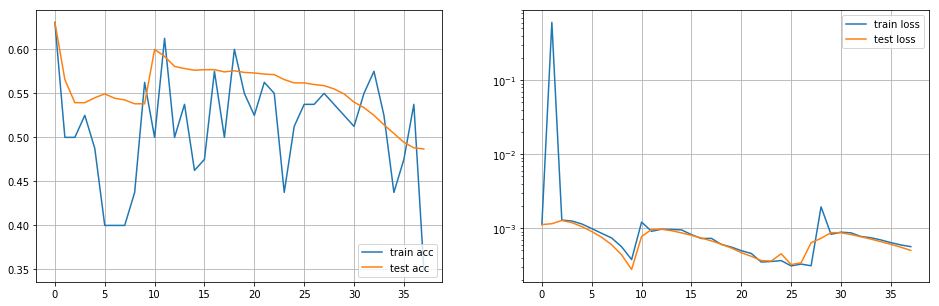

Loss, accuracy: 0.00047021123, 0.875 @ batch 375 (3000 samples) complete.                  

KeyboardInterrupt: 

In [52]:
print(gc.collect())
iterate_training()

In [48]:
# Load best model (checkpoint)
pt.cuda.empty_cache()
gc.collect()
cpoint = pt.load("./models/" + model_name + '/' + model_name)
# cpoint = pt.load("./models/" + 'ernst_one - 2k ts' + "/" + model_name)
# cpoint = pt.load("./models/" + 'ernst_one - 3k ts' + "/" + model_name)  # ~3000 training samples observed has current optimum
# cpoint = pt.load("./models/" + 'ernst_one - 30k ts' + "/" + model_name)
model.load_state_dict(cpoint['model'])
bcewl_loss.load_state_dict(cpoint['bcewl_loss'])
optimizer.load_state_dict(cpoint['optimizer'])
scheduler.load_state_dict(cpoint['scheduler'])
# llayer.load_state_dict(cpoint['llayer'])
mname_fn = model_name

In [87]:
def top_k_top_p_temperature_filtering(logits, tcounts=None, filter_value=-float('Inf'),
                                      top_k=0, top_p=0.0, temperature=1.0, frequency_penalty=0.0, presence_penalty=0.0):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if tcounts is not None: logits -= (tcounts * frequency_penalty) + ((tcounts > 0) * presence_penalty)
    logits /= temperature
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < pt.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = pt.sort(logits, descending=True)
        cumulative_probs = pt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
        
    return logits

In [92]:
padder = int(pad_token.detach().cpu().numpy())
# stop_tokens_e = [tokenizer.encode(t)[0] for t in ["<|endoftext|>"]]
def gprobs(s, past=None, return_sts=False, tcounts=None, **kwargs):  # Inference and sampling for tokens
    global model
    xs, mlen = None, None
    if isinstance(s, tuple):    # s either list of token tensors or tuple of preformatted 2d tensors
        xs, _, sqlen = s
        mlen = xs.shape[1]
    else:
        sqlen = [len(s_) for s_ in s]
        mlen = max(sqlen)
        xs, _, sqlen = adapt_form([pt.tensor(s_).to(d) for s_ in s], None, sqlen, mlen=mlen)
    if dev != "cpu": pt.cuda.empty_cache()
    model.eval()
    y_hat = inference(xs, sqlen, seq_maxlen=mlen, past=past, return_states=return_sts)
    if return_sts: y_hat, states = y_hat
    y_hat = pt.vstack([F.softmax(top_k_top_p_temperature_filtering(y_hat[i], tcounts[i] if tcounts is not None else None,
                                                                   **kwargs), dim=0) for i in range(len(s))])
    return (y_hat, states) if return_sts else y_hat
def append_next_token(sent, olen=None, top_k=-1, top_p=0.9, temperature=1.0):  # Interface for field testing
    print("k =", top_k, ", p =", top_p, ", temp =", temperature)
    tokens = tokenizer.encode(sent)
    ou = tokens.copy()
    tcounts = pt.zeros(N_tokens, dtype=int).to(d)
    for token in tokens: tcounts[token] += 1
    probs = gprobs([tokens], top_k=top_k, top_p=top_p, temperature=temperature, tcounts=[tcounts])[0]
    token = pt.multinomial(probs, 1).detach().cpu().numpy()[0]
    ou += [token]
    prev_len = len(sent) if olen is None else olen
    sent_new = tokenizer.decode(ou)
    print(sent[:prev_len] + '➡' + sent_new[prev_len:])
    return sent_new
def gen_probs(s, **kwargs):  # Adapter for strings
    inp = [tokenizer.encode(s_) for s_ in s]
    return gprobs(inp, **kwargs)
# bszinf = 256
bszinf = bsz * 16
def gen_completions(s, n=1, max_tokens=8, best_of=1, **kwargs):  # Completion generator equivalent to OpenAI's for GPT3
    probs, states, tcounts, n_outer_batches, best_of = [], [], [], int(np.ceil(len(s) / (bsz // 2))), int(round(best_of))
    best_of_inner = 1 if (best_of != 1 and n != 1) else best_of
#     if best_of != 1 and n != 1: n, best_of, best_of_inner = best_of, n, 1
    for i in range(n_outer_batches):
        s_batch = s[i * (bsz // 2):(i + 1) * (bsz // 2)]
        tc_b = []
        for s_ in s_batch:
            tc = pt.zeros(N_tokens, dtype=int).to(d)
            for t in tokenizer.encode(s_): tc[t] += 1
            tc_b.append(tc)
        p, st = gen_probs(s_batch, return_sts=True, tcounts=tc_b, **kwargs)
        probs.append(p)
        states.append(st)
        tcounts.append(tc_b)
    inner_bsz = int(bszinf / ((bsz // 2) * n))
    n_inner_batches = int(np.ceil(n_outer_batches / inner_bsz))
    outputs = []
    for i in range(n_inner_batches):
        p_b, st_b = probs[i * inner_bsz:(i + 1) * inner_bsz], states[i * inner_bsz:(i + 1) * inner_bsz]
        tc_b = sum(tcounts[i * inner_bsz:(i + 1) * inner_bsz], [])
        p_b, states = pt.vstack(p_b), []
        for st_i in range(len(st_b[0])):
            sts = []
            for st_j in range(len(st_b[0][0])): sts.append(pt.vstack([st[st_i][st_j] for st in st_b]).repeat_interleave(n, 0))
            states.append(tuple(sts))
        states = tuple(states)
        tokens = pt.multinomial(p_b, n * best_of_inner, replacement=True).reshape(p_b.shape[0], best_of_inner, n).to(d)
        for j in range(len(tc_b)): tc_b[j][tokens[j]] += 1
        outs, avg_logprobs = [], []
        for itr in range(best_of_inner):
            out, tc_b_ = [], tc_b.copy()
            tks, ts, su, ls = tokens[:, itr].reshape(p_b.shape[0] * n), [], pt.zeros(p_b.shape[0]), np.zeros(p_b.shape[0])
            p, st = gprobs(tks, past=states, return_sts=True, tcounts=tc_b, **kwargs)
            for token_i in range(max_tokens):
                t = pt.multinomial(p, 1).to(d)
                for j in range(len(tc_b_)): tc_b_[j][t[j]] += 1
                out.append(t)
                cont = t != pad_token
                ls += cont.int()
                su += cont * pt.log(p[t])
                if t == max_tokens - 1: break
                p, st = gprobs(t, past=st, return_sts=True, tcounts=tc_b_, **kwargs)
            outs.append([o.reshape(p_b.shape[0], n) for o in out])
            avg_logprobs.append((su / ls).reshape(p_b.shape[0], n))
        if best_of == 1:
            outs = pt.stack(outs[0], dim=1)
        elif n == 1:
            outs, lps = pt.stack([pt.stack(o, dim=1) for o in outs]), pt.stack(avg_logprobs)
            s1, s2 = outs.shape[1], outs.shape[2]
            outs = outs[[pt.argmin(lps, 0).view(-1), pt.arange(s1).repeat_interleave(s2), pt.arange(s2).repeat(s1, 1).view(-1)]]
        else:
            outs = pt.stack(outs[0], dim=1)
            s1 = outs.shape[1]
            idx = pt.argsort(avg_logprobs[0], axis=1)[:, :best_of].repeat((1, 1, max_tokens)).reshape(s1, max_tokens, best_of)
            outs = pt.gather(outs, 2, idx)
        outputs.append(outs)
    outputs = [tokenizer.decode(x).split("\n")[0] for x in pt.vstack(outputs)]
    return outputs
mdl = {"completions": gen_completions, "probabilities": gprobs, "name": mname_fn + ':' + gpt2_modelkey, "mstr": str(model)}

In [111]:
pt.arange(8).repeat(10).reshape(10, 8)[pt.arange(10), pt.arange(5).repeat(10).reshape(5, 10)]

tensor([[0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4]])

In [122]:
testa = pt.arange(8).repeat(10).reshape(10, 8) * 2
testa[:5] = -testa[:5]
testa

tensor([[  0,  -2,  -4,  -6,  -8, -10, -12, -14],
        [  0,  -2,  -4,  -6,  -8, -10, -12, -14],
        [  0,  -2,  -4,  -6,  -8, -10, -12, -14],
        [  0,  -2,  -4,  -6,  -8, -10, -12, -14],
        [  0,  -2,  -4,  -6,  -8, -10, -12, -14],
        [  0,   2,   4,   6,   8,  10,  12,  14],
        [  0,   2,   4,   6,   8,  10,  12,  14],
        [  0,   2,   4,   6,   8,  10,  12,  14],
        [  0,   2,   4,   6,   8,  10,  12,  14],
        [  0,   2,   4,   6,   8,  10,  12,  14]])

In [174]:
testa_data = pt.stack([testa, testa, testa], dim=1)
testa_data[0, 2] -= 100
testa_data.shape, testa_data

(torch.Size([10, 3, 8]),
 tensor([[[   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [-100, -102, -104, -106, -108, -110, -112, -114]],
 
         [[   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14]],
 
         [[   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14]],
 
         [[   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14]],
 
         [[   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14],
          [   0,   -2,   -4,   -6,   -8,  -10,  -12,  -14]],
 
         [[   0,    2,    4,    6,    8,   10,   12,   14],


In [175]:
ind = pt.argsort(testa, axis=1)[:, :5].repeat((1, 1, 3)).reshape(10, 3, 5)
ind.shape, ind

(torch.Size([10, 3, 5]), tensor([[[7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3]],
 
         [[7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3]],
 
         [[7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3]],
 
         [[7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3]],
 
         [[7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3],
          [7, 6, 5, 4, 3]],
 
         [[0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4]],
 
         [[0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4]],
 
         [[0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4]],
 
         [[0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4]],
 
         [[0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4],
          [0, 1, 2, 3, 4]]]))

In [176]:
pt.gather(testa_data, 2, ind)

tensor([[[ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6],
         [-114, -112, -110, -108, -106]],

        [[ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6]],

        [[ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6]],

        [[ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6]],

        [[ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6],
         [ -14,  -12,  -10,   -8,   -6]],

        [[   0,    2,    4,    6,    8],
         [   0,    2,    4,    6,    8],
         [   0,    2,    4,    6,    8]],

        [[   0,    2,    4,    6,    8],
         [   0,    2,    4,    6,    8],
         [   0,    2,    4,    6,    8]],

        [[   0,    2,    4,    6,    8],
         [   0,    2,    4,    6,    8],
         [   0,    2,    4,    6,    8]],



In [93]:
# evaluate un-fine-tuned model
# test the non fine tuned davinci
lgroups_ft = [[4, 5]]
bounds_gptxl = {
  "temperature": [0.01, 2.0],  # a temp of 0 selects the top completion every time due to the infinitely larger logit
  "top_p": [0.01, 1.0],        # same with this but more obvious
#   "top_k": [1, 100],        # fix this to be a log of the input value so that lower values are sampled with high resolution?
  "presence_penalty": [0.01, 2.0],   # both presence and frequency penalty have optimal values
  "frequency_penalty": [0.01, 2.0],  # this can also go down to -2.0, probably not useful for our case...
#   "best_of": [0.51, 5.49], # to do
}
optimizers_gpt2xl, results_gpt2xl = [], []
for lgroup in lgroups_ft:
    min_l, max_l = min(lgroup) - 1, max(lgroup)
    def fun(temperature, top_p, presence_penalty, frequency_penalty):
        global min_l, max_l
        ps = locals()
        ps["best_of"] = 5.0
        return test_sp_conv(ps, min_l=min_l, max_l=max_l, tol=0.005, phase="train", uniform=True, mdl=mdl)[0]
    optimizers_gpt2xl.append(BayesianOptimization(f=fun, pbounds=bounds_gptxl, verbose=1000))
    optimizers_gpt2xl[-1].maximize(init_points=8, n_iter=10)
    results_gpt2xl.append(optimizers_gpt2xl[-1].max)

|   iter    |  target   | freque... | presen... | temper... |   top_p   |
-------------------------------------------------------------------------


TypeError: multinomial(): argument 'num_samples' (position 2) must be int, not float

# Interactive generation

In [547]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
"reinterpretation, harmony, character progression, reading circle")
# "monolith, elevator effect, time loop, survival, desert resort, town watchman")
# "monolith, allegro, soundtrack, chord, classical, opera")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
olen = len(input_sentence)

In [559]:
input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.6, temperature=15.0, olen=olen)

k = 25 , p = 0.6 , temp = 15.0
 A list of types of element of drama and writing: attention, surprise, fourth wall, diversion, fate, silence, pace, cliffhanger, character progression, monologuereinterpretation,➡, reading circle, cliffhaft-style character progression


In [739]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
"watermelon juice, cherry juice, blackcurrant mixture, kava, orangeade, lemon juice, cherryade, cranberry juice")
input_sentence = input_sentence.split(', ')
np.random.shuffle(input_sentence)
input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', '
olen = len(input_sentence)

In [740]:
input_sentence = append_next_token(input_sentence, top_k=10, top_p=0.8, temperature=5.0, olen=olen)

k = 10 , p = 0.8 , temp = 5.0
A list of types of element of drama and writing: kava, lemonade, coffee, milkshakewatermelon juice, coke, orangeade, blackcurrant mixture, water, cherry juice, lemon juice, ➡ black


In [686]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("pace, silence, diversion, attention, plot twist, cliffhanger, surprise, fate, fourth wall, monologue" + \
# "")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of element of drama and writing: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)
# input_sentence = append_next_token(input_sentence, top_k=5, top_p=0.9, temperature=5.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider, yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# # With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# # Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake" + \
# ", liquor, wine, juice, beer, milk, soft drink, whiskey, vodka, spirits, soda, ice water, ice cold beer, cider" + \
# ", yoghurt, soda pop, rum, chocolate milk, hot cocoa, alcohol")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5pm: Using log_period=1 (max_len=96) reliably finds improvement, need more data and larger gpt2 (medium+)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " milk, vodka, beer, ice water, soda, lassi, juice, alcohol, whiskey")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=2.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " wine, soda, alcohol, beer, liquor, apple cider, whiskey, milk, bourbon, vodka, cider, lemon juice")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:6])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=3.0, olen=olen)

In [ ]:
# With about half an hour of fine-tuning using 7 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake," + \
# " beer, milk, juice, wine, spirits, alcohol, soda, whiskey, brandy, apple juice, liquor, ice tea, watermelon juice, vodka," + \
# " lemon tea, apple cider, ale, lager, fruit tea, lime cider, cocktail, mocha, red wine, apple soda")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=30, top_p=0.7, temperature=2.0, olen=olen)

In [ ]:
# Changelog 16/04/2021 5am: lr=1e-5, max_len=80, log_period_batches=5 increased accuracy by 8%. Need to add a bunch more data

In [ ]:
# With about half an hour of fine-tuning using 5 training samples on an NVidia 980 Ti (showing improvements):
# Initial input words on first line, those eventually found by repeatedly querying model + recursively adding words on 2nd & 3rd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "soda, milk, juice, wine, vodka, gin, lime juice, beer, hot chocolate, cider, whiskey, fruit juice, cocktail, liquor, " + \
# "spirits, watermelon juice, martini, rum, chocolate milk, orangeade")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Without fine tuning (regular GPT-2):
# Initial input words on first line, those eventually found by repeatedly querying model on 2nd
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "milk, juice, fruit juice, soda, wine, beer, hot chocolate, chocolate milk, alcohol, cider, ice tea, liquor, spirit")
# input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89, olen=olen) # k = 25 also used

In [ ]:
# Training for too long (in this case ~6:30 hours) overfits
# input_sentence = ("coffee, water, tea, coke, lemonade, milkshake, " + \
# "beer, juice, soda, liquor, wine, tequila, spirits, alcohol, cocktail, martini, whiskey, rum, vodka")
# input_sentence = input_sentence.split(', ')
# np.random.shuffle(input_sentence)
# input_sentence = "A list of types of drink: "+', '.join(input_sentence[:10])+', ' # Randomly generate shuffled drinks sublist
# olen = len(input_sentence)
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.9, temperature=1.89, olen=olen)

In [ ]:
# Changelog 15/04/2021 11am: Found learning rate 1e-7, max_listlen 15, min_nw 0.7, max_nw 0.9, lidstone_e 0.01 ACTUALLY WORKS

In [ ]:
# No fine tuning (testing gpt2) (old append function):
# input_sentence = "A list of types of drink: coffee, water, tea, coke, lemonade, milkshake"
# input_sentence = append_next_token(input_sentence, top_k=25, top_p=0.75, temperature=1.89)
# A list of types of drink: juice, tea, cider, lemonade, milk, beer, hot chocolate,➡ ice cold milk. Image

Working (reproducible) examples using various non-fine-tuned models:

In [ ]:
# GPT3 (via AI Dungeon) (Randomness = 2.0, model = Dragon):
# sentence = "A list of ML algorithms: inverse reinforcement learning, ELMo, decision tree, LDA, "
# expected_completion = "MLP, MLL, MMM. You can't believe you're actually using these things!"

# sentence = "A list of animals seen in the wild: wolffish, woodlouse, sheep, zebra, yak, "
# expected_completion = "goat, fox, dog, rat. You're guessing that a lot of other animals have been seen as well; maybe even all the animals on your list except for wolf and rat?"

In [ ]:
# GPT2 (via Write with Transformer) (Top-p = 0.67, temperature = 1.89, max time = 1.9):
# sentence = "A list of round fruits: peach, apricot, lime, plum, blackberry, cantaloupe, nectarine, pitaya, persimmon, "
# expected_completion = "mango, papaya and raspberry, as also many"

# sentence = "A list of chemical elements: hydrogen, carbon, oxygen, nitrogen, gold, "
# expected_completion = "silver, aluminum, potassium and phosphorus; atomic number."

# sentence = "A list of microbes found on earth: bacteria, virus, prokaryote, amoeba, "
# expected_completion = "archaea, algae, nematode, euk"

In [133]:
# This result shows why we need not redistribute the mass when evaluating gpt3 accuracy
# response = openai.Completion.create(**{**default_params,
#   "prompt": "A list of cyclic phenomena: day and night, induction coil, self-oscillation, tornado, runaway greenhouse effect,",
#   "temperature": 1.5,
#   "top_p": 1.0,
#   "n": 5,
#   "best_of": 20,
#   "max_tokens": 7,
#   "stop": [",", "\n"],
# })
# for choice in response["choices"]:
#     d = {}
#     tokens = choice["logprobs"]["tokens"]
#     t_i = -1
#     for t in tokens:
#         t_i += 1
#         r = [(np.e**v, k) for (k, v) in choice["logprobs"]["top_logprobs"][t_i].items()]
#         r.sort(reverse=True)
#         print(sum([v for (v, k) in r]))
#         rd = dict([(k, v) for (v, k) in r])
#         r = [k for (v, k) in r]
#         d[t] = (rd, r, np.e**choice["logprobs"]["token_logprobs"][t_i])
#     print('|'.join([' '.join((s.replace("\n", "⏎"),'%.2f' % (d[s][2] * 100),
#                               str(d[s][1].index(s) + 1) if s in d[s][1] else "<100")) for s in tokens]))

0.4717125622130082
0.9274901414219993
0.9708372719995181
0.9749693956398692
0.9634897148058369
0.9896781399013229
0.49241673846869144
 laser 0.13 <100| warming 0.00 <100| of 13.07 2| the 66.63 1| earth 11.92 2|, 68.96 1| vortex 0.12 <100
0.4717126591849034
0.9892794505344922
0.7311559539240653
0.9564361800508027
0.9806930894447073
0.9902743788718463
0.40462574025242265
 peaks 0.00 <100| of 46.80 1| power 0.03 <100| distribution 0.86 17| systems 3.02 3|, 81.74 1| thunder 0.31 38
0.4717126591849034
0.9953395055269428
0.9999771481604979
0.9590532795958426
0.3408734530984889
0.8934024084657903
0.9621786642515812
 ping 0.01 <100| p 33.01 2|ong 99.66 1|, 14.11 2| sound 0.25 42| stimuli 0.00 <100| and 4.08 3
0.47171274389095824
0.9298754919398827
0.9241370285266322
0.9774319808776988
0.969552997269808
0.9904618264585953
0.9982023300946802
 bird 0.01 <100| flipping 0.01 <100| its 16.03 2| wing 6.92 3| sixty 0.00 <100| times 69.92 1| a 57.81 1
0.4717125622130082
0.9986656739204779
0.99979994859

In [239]:
C, H, W = 3, 4, 4
x = pt.arange(C*H*W).view(C, H, W)
print(x)
idx = pt.tensor([[0, 0],
                    [1, 1],
                    [2, 2],
                    [3, 3]])

# print(x[list((pt.arange(x.shape[0]), *idx.chunk(2, 1)))])
print(x[[pt.arange(3), [1, 3, 2]]])

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]],

        [[32, 33, 34, 35],
         [36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]]])
tensor([[ 4,  5,  6,  7],
        [28, 29, 30, 31],
        [40, 41, 42, 43]])


In [528]:

        else:            outs = pt.gather(pt.stack(outs), 0, pt.unsqueeze(pt.unsqueeze(
                           pt.argmin(pt.stack(avg_logprobs), 0), dim=0), dim=3).repeat_interleave(max_tokens, 3))

' what is this, he said.'

In [322]:
(pt.tensor(np.array(5)) != pt.tensor(np.array([5, 5, 7]))).int() + (pt.tensor(np.array(5)) != pt.tensor(np.array([5, 5, 7]))) 

tensor([0, 0, 2], dtype=torch.int32)

In [376]:
pt.stack([pt.tensor(np.array([[[9,-9,0],[8,-8,0],[7,-7,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]]])), pt.tensor(np.array([[[1,-1,0],[9,-9,0],[9,-9,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]]]))])

tensor([[[[ 9, -9,  0],
          [ 8, -8,  0],
          [ 7, -7,  0]],

         [[ 1, -1,  0],
          [ 2, -2,  0],
          [ 3, -3,  0]],

         [[ 1, -1,  0],
          [ 2, -2,  0],
          [ 3, -3,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]]],


        [[[ 1, -1,  0],
          [ 9, -9,  0],
          [ 9, -9,  0]],

         [[ 1, -1,  0],
          [ 2, -2,  0],
          [ 3, -3,  0]],

         [[ 1, -1,  0],
          [ 2, -2,  0],
          [ 3, -3,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]]]], dtype=torch.int32)

In [437]:
pt.unsqueeze(pt.unsqueeze(pt.argmax(pt.stack([pt.tensor(np.array([[9,8,7], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), pt.tensor(np.array([[1,9,9], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]]))]), 0), dim=0),dim=3).repeat_interleave(5, 3)

tensor([[[[0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]],

         [[0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0]]]])

In [470]:
pt.unsqueeze(pt.unsqueeze(pt.argmax(pt.stack([pt.tensor(np.array([[9,8,7], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), pt.tensor(np.array([[1,9,9], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]]))]), 0), dim=0),dim=0).transpose(0, 3)

tensor([[[[0],
          [0],
          [0],
          [0],
          [0],
          [0]]],


        [[[1],
          [0],
          [0],
          [0],
          [0],
          [0]]],


        [[[1],
          [0],
          [0],
          [0],
          [0],
          [0]]]])

In [475]:
ind_tensor.view(-1)

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [360]:
pt.stack([pt.tensor(np.array([[9,8,7], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), pt.tensor(np.array([[1,9,9], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]]))]).shape

torch.Size([2, 6, 3])

In [494]:
z[[pt.arange(z.shape[0]).repeat_interleave(18//z.shape[0], 0), pt.arange(z.shape[1]).repeat_interleave(z.shape[1]), ind_tensor.view(-1)]]

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [522]:
z[[ind_tensor.view(-1), pt.arange(z.shape[1]).repeat_interleave(z.shape[2]),
                        pt.arange(z.shape[2]).repeat(z.shape[1], 1).view(-1)]]

tensor([[ 9, -9,  0],
        [ 9, -9,  0],
        [ 9, -9,  0],
        [ 1, -1,  0],
        [ 2, -2,  0],
        [ 3, -3,  0],
        [ 1, -1,  0],
        [ 2, -2,  0],
        [ 3, -3,  0],
        [10, -7,  0],
        [ 6, -7,  0],
        [ 6, -6,  0],
        [74, -4,  0],
        [ 5, -5,  0],
        [ 6, -6,  0],
        [ 4, -4,  0],
        [ 5, -5,  0],
        [ 6, -6,  0]], dtype=torch.int32)

18

In [501]:
z.shape

torch.Size([2, 6, 3, 3])

In [500]:
pt.arange(z.shape[2]).repeat(18//z.shape[2], 1).view(-1)

tensor([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])

In [498]:
pt.arange(z.shape[1]).repeat_interleave(18//z.shape[1])

tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5])

In [512]:
z = pt.stack([pt.tensor(np.array([[[9,-9,0],[8,-8,0],[7,-7,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]]])), pt.tensor(np.array([[[1,-1,0],[9,-9,0],[9,-9,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[10,-7,0],[6,-7,0],[6,-6,0]], [[74,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[6,-5,0],[6,-6,0]]]))])
ind_tensor = pt.argmax(pt.stack([pt.tensor(np.array([[9,8,7], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), pt.tensor(np.array([[1,9,9], [1,2,3], [1,2,3], [12,9,6], [80,5,6], [4,5,6]]))]), 0)
pt.gather(z, 0, pt.unsqueeze(pt.unsqueeze(ind_tensor, dim=0), dim=3).repeat_interleave(3, 3))

tensor([[[[ 9, -9,  0],
          [ 9, -9,  0],
          [ 9, -9,  0]],

         [[ 1, -1,  0],
          [ 2, -2,  0],
          [ 3, -3,  0]],

         [[ 1, -1,  0],
          [ 2, -2,  0],
          [ 3, -3,  0]],

         [[10, -7,  0],
          [ 6, -7,  0],
          [ 6, -6,  0]],

         [[74, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]],

         [[ 4, -4,  0],
          [ 5, -5,  0],
          [ 6, -6,  0]]]], dtype=torch.int32)

In [469]:
z = pt.stack([pt.tensor(np.array([[[9,-9,0],[8,-8,0],[7,-7,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]]])), pt.tensor(np.array([[[1,-1,0],[9,-9,0],[9,-9,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[1,-1,0],[2,-2,0],[3,-3,0]], [[10,-7,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]], [[4,-4,0],[5,-5,0],[6,-6,0]]]))])
ind_tensor = pt.argmax(pt.stack([pt.tensor(np.array([[9,8,7], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), pt.tensor(np.array([[1,9,9], [1,2,3], [1,2,3], [10,5,6], [4,5,6], [4,5,6]]))]), 0)
pt.gather(z.transpose(0, 3), 0, pt.unsqueeze(pt.unsqueeze(ind_tensor, dim=0), dim=0).transpose(0, 3))

RuntimeError: Size does not match at dimension 2 expected index [3, 1, 6, 1] to be smaller than src [3, 6, 3, 2] apart from dimension 0

In [452]:
z.transpose(0, 3)

tensor([[[[ 9,  1],
          [ 8,  9],
          [ 7,  9]],

         [[ 1,  1],
          [ 2,  2],
          [ 3,  3]],

         [[ 1,  1],
          [ 2,  2],
          [ 3,  3]],

         [[ 4, 10],
          [ 5,  5],
          [ 6,  6]],

         [[ 4,  4],
          [ 5,  5],
          [ 6,  6]],

         [[ 4,  4],
          [ 5,  5],
          [ 6,  6]]],


        [[[-9, -1],
          [-8, -9],
          [-7, -9]],

         [[-1, -1],
          [-2, -2],
          [-3, -3]],

         [[-1, -1],
          [-2, -2],
          [-3, -3]],

         [[-4, -7],
          [-5, -5],
          [-6, -6]],

         [[-4, -4],
          [-5, -5],
          [-6, -6]],

         [[-4, -4],
          [-5, -5],
          [-6, -6]]],


        [[[ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         [[ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         [[ 0,  0],
          [ 0,  0],
          [ 0,  0]],

         [[ 0,  0],
          [ 0,  0],
          [ 0,  0]],

    

In [361]:
pt.argmax(pt.stack([pt.tensor(np.array([[9,8,7], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), pt.tensor(np.array([[1,9,9], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]]))]), 0).shape

torch.Size([6, 3])

In [297]:
pt.tensor(np.array([[5, 4], [5, 7]])).repeat_interleave(5, 0)

tensor([[5, 4],
        [5, 4],
        [5, 4],
        [5, 4],
        [5, 4],
        [5, 7],
        [5, 7],
        [5, 7],
        [5, 7],
        [5, 7]], dtype=torch.int32)

In [273]:

pt.multinomial(pt.tensor(np.array([[1.,0,0], [1,2,3], [1,2,3], [4,5,6], [4,5,6], [4,5,6]])), 3, replacement=True).reshape(3, 2, 3)[:, 0].reshape(9)

tensor([0, 0, 0, 2, 1, 2, 0, 1, 0])